In [7]:
!pip install neuromancer

In [8]:
!pip install gymnasium

In [2]:
from dpc_ssm import DictDataset_L as StridedDataset # TODO: change this to neuromancer import once PR is merged

from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.dataset import DictDataset
from neuromancer.system import Node, System
from neuromancer.constraint import variable
from neuromancer.problem import Problem
from neuromancer.loss import PenaltyLoss
from neuromancer.trainer import Trainer
from neuromancer.loggers import MLFlowLogger
from neuromancer.psl.signals import signals

from neuromancer.dataset import DictDataset
from neuromancer.psl.plot import plot_pendulum_sysid
from neuromancer.psl.plot import plot_acrobot_sysid
from neuromancer.psl.plot import plot_pendulum_control
from neuromancer.psl.plot import plot_acrobot_control
from neuromancer.psl.plot import render_gymnasium
from neuromancer.psl.nonautonomous import GymnasiumPendulum, GymnasiumAcrobot
from neuromancer.psl.gymnasium_environments.gym_utils import wrap

import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import warnings
warnings.filterwarnings('ignore')

def discrete_random_walk(nsim, d=1, min=-1, max=+1, p=0.3, rng=np.random.default_rng()):
	U = np.zeros((nsim, d), dtype=np.float32)
	u = rng.choice([min, 0, max])
	for n in range(0, nsim):
		U[n, :] = u
		if rng.uniform()<p:
			u = rng.choice([min, 0, max])
	return U

signals['discrete'] = discrete_random_walk


# What Are We Learning
We are learning how to use Blackbox DPC to control either an Acrobot or Pendulum system.
Blackbox DPC is a two stage process, wherein you first learn a Neural State Space Model (NSSM), which is just a surrogate model for unlimited _and fast_ interaction for the controller to learn from.
Once we have this learned representation of the orignal system, we are going to let our controller learn to control that, then evaluate it on the original system.

![pendulum](https://gymnasium.farama.org/_images/pendulum.gif)  ![acrobot](https://gymnasium.farama.org/_images/acrobot.gif)

$$
\begin{align*}
\textbf{Pendulum System} \\
\dot{\theta} &= \omega \\
\ddot{\theta} &= \frac{3g}{2l} \sin(\theta) + \frac{3u}{ml^2} \\
\omega_{\text{new}} &= \omega + \left( \frac{3g}{2l} \sin(\theta) + \frac{3u}{ml^2} \right) \cdot \Delta t \\
\omega_{\text{new}} &= \text{clip}(\omega_{\text{new}}, -\omega_{\text{max}}, \omega_{\text{max}}) \\
\theta_{\text{new}} &= \theta + \omega_{\text{new}} \cdot \Delta t \\
\end{align*}

\begin{align*}
\textbf{Acrobot System} \\
d_1 &= m_1 \cdot lc_1^2 + m_2 \cdot (l_1^2 + lc_2^2 + 2 \cdot l_1 \cdot lc_2 \cdot \cos(\theta_2)) + I_1 + I_2 \\
d_2 &= m_2 \cdot (lc_2^2 + l_1 \cdot lc_2 \cdot \cos(\theta_2)) + I_2 \\
\phi_2 &= m_2 \cdot lc_2 \cdot g \cdot \cos(\theta_1 + \theta_2 - \frac{\pi}{2}) \\
\phi_1 &= -m_2 \cdot l_1 \cdot lc_2 \cdot \dot{\theta_2}^2 \cdot \sin(\theta_2) - 2 \cdot m_2 \cdot l_1 \cdot lc_2 \cdot \dot{\theta_2} \cdot \dot{\theta_1} \cdot \sin(\theta_2) \\
&\quad + (m_1 \cdot lc_1 + m_2 \cdot l_1) \cdot g \cdot \cos(\theta_1 - \frac{\pi}{2}) + \phi_2 \\
\ddot{\theta_2} &= \frac{a + \frac{d_2}{d_1} \phi_1 - m_2 \cdot l_1 \cdot lc_2 \cdot \dot{\theta_1}^2 \cdot \sin(\theta_2) - \phi_2}{m_2 \cdot lc_2^2 + I_2 - \frac{d_2^2}{d_1}} \\
\ddot{\theta_1} &= -\frac{d_2 \cdot \ddot{\theta_2} + \phi_1}{d_1}
\end{align*}
$$

If you want to learn more about the original systems you can reference the following documentation
| Pendulum | Acrobot |
| --- | --- |
| https://gymnasium.farama.org/environments/classic_control/pendulum/ | http://incompleteideas.net/papers/sutton-96.pdf |

# Deciding the Environment
At this point you can make a decision of which environment you want to learn a control policy for, you can make this choice by changing the `env_str` in the cell below.

In [1]:
# env_str = "pendulum"
env_str = "acrobot"

# Learning a Neural State Space Model of the Farama Environment

## Creating a Closed Loop System

### What is a Neural State Space Model (NSSM)?
An NSSM is a Neural Network that that is trying to replicate a true system or "plant". These can be trained using historical data of interaction in the form of state action tuple pairs $(y_t, u_t) \rightarrow (y_{t+1})$.

### How do we create a NSSM
To create a NSSM, it has to have the same input and output dimension as the original system, but we want to ensure that our NSSM is going to strictly produce states that could feasibly exist in the state space.
To acheive this we will augment the output of this by placing all of the states on the unit circle.

### How do we ensure state feasibility?
With the both the Pendulum and Acrobot system, all of our output states have very well defined bounds.
An issue with Neural Networks, is that they produce values on a continuum, and are not guarenteed to produce valid states, but we can correct this!
In the case of $\dot \theta$, we can simply apply a scaled and shifted sigmoid to the output of out the NSSM at those state variable locations!
But for the other state variables, they need to be valid coordinates along the unit circle, thus we need to write a small function to place those outputs on the unit circle.

In [3]:
envs = {
    "pendulum": GymnasiumPendulum,
    "acrobot": GymnasiumAcrobot
}
env = envs[env_str]()
mlp = blocks.MLP(
    env.ny + env.nu,
    env.ny,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=activations["relu"],
    hsizes=[128 for h in range(2)],
)
system_node = Node(mlp, ["yn", "U"], ["approx_yn"], name="mlp")

# Ensure that all states that come out of the NSSM are valid
if env_str == "pendulum":
    def unit_circleify(x):
        return torch.cat(
            (
                x[:, :2] / torch.sqrt(torch.sum(x[:, :2] ** 2, axis=1).reshape(-1, 1)),
                torch.nn.functional.tanh(x[:, 2:3]) * 8,
            ),
            dim=1,
        )
elif env_str == "acrobot":
    torch.pi = torch.acos(torch.zeros(1)).item() * 2 # which is 3.1415927410125732
    def unit_circleify(x):
        return torch.cat(
            (
                x[:, :2] / torch.sqrt(torch.sum(x[:, :2] ** 2, axis=1).reshape(-1, 1)),
                x[:, 2:4]
                / torch.sqrt(torch.sum(x[:, 2:4] ** 2, axis=1).reshape(-1, 1)),
                torch.nn.functional.tanh(x[:, 4:5]) * 4 * torch.pi,
                torch.nn.functional.tanh(x[:, 5:6]) * 9 * torch.pi,
            ),
            dim=1,
        )

unit_circleify = Node(unit_circleify, ["approx_yn"], ["yn"], name="unit_circleify")
cl_system = System([system_node, unit_circleify], name="NSSM")

## Dataset Generation
We sample random sequences of perturbations, then roll the simulation out
from some initial condition. We find that a "discrete" action signal works
quite well at maximizing the variance of both the Acrobot and Pendulum system.
We also found that for training it was best to decouple the the length of the 
rollout in our dataset from the prediction horizon. The way that we can accomplish
this is by "chunking" our data into smaller sequence lengths.
We get this benefit, but we can actually use these overlapping chunks to allow for 
even more efficient usage of data.

Let's take a look at what this "discrete" perturbation signal looks like!

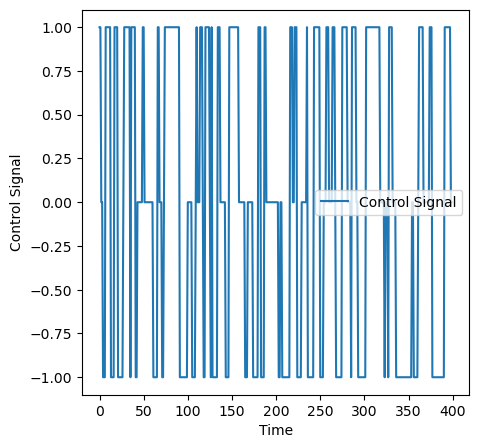

In [4]:
u = env.get_U(nsim=400, signal=discrete_random_walk)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(u, label="Control Signal")
ax.set_xlabel("Time")
ax.set_ylabel("Control Signal")
ax.legend()
plt.show()

In [5]:
def get_farama_dataset(nsim, nsteps, L, name):
    def update_yn(d):
        d["yn"] = d["Y"][0:1, :]

    x_list = []
    y_list = []
    u_list = []

    for i in tqdm(range(nsim), desc=f"Getting {name} data..."):
        signal = random.choice(list(signals.values()))
        u = env.get_U(nsim=nsteps, signal=signal)
        u_list.append(u)
        sim = env.simulate(nsim=nsteps, U=u, x0=env.get_x0())
        x_list.append(sim["X"])
        y_list.append(sim["Y"])

    X = torch.stack(x_list, dim=0).reshape(nsim, nsteps, -1)
    Y = torch.stack(y_list, dim=0).reshape(nsim, nsteps, -1)
    U = torch.stack(u_list, dim=0).reshape(nsim, nsteps, -1)

    data = {
        "X": X,
        "Y": Y,
        "U": U,
    }

    dataset = StridedDataset(data, stride=1, L=L, update_fn=update_yn, name=name)
    return torch.utils.data.DataLoader(
        dataset,
        collate_fn=dataset.collate_fn,
        batch_size=2**14, # Arbitraily large number
        shuffle=True
      )

dev_loader = get_farama_dataset(
    nsim=20,
    nsteps=500,
    L=2,
    name="dev",
)

train_loader = get_farama_dataset(
    nsim=100,
    nsteps=500,
    L=2,
    name="train",
)


Getting train data...: 100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


# NSSM Reference Tracking Loss
To train the state space model for this system, we need a set of constraints and objectives, we will do this by using the `PenaltyLoss` in neuromancer.
The objective function that we use for training these state space models is a reference tracking loss, which penalizes the difference between the predicted state and the true state over the full time sequence.

One thing to note is that since we are using a `DictDataset` object, all sequence lengths must be equal, such that, `len(U) == len(Y) == len(X)`, but that means if we give our state space model `k` steps of control, it will produce `k+1` state spaces. We don't have a label for that final state space, so we remove it in our loss function.

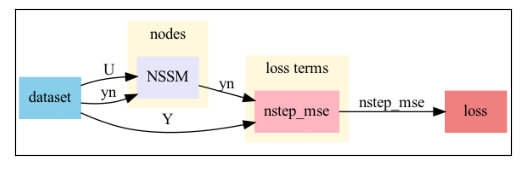

In [6]:
xpred = variable("yn")[:, :-1, :]
xtrue = variable("Y")

# Minimize the squared error between predicted states and true states
nstep = (xpred == xtrue) ^ 2
nstep.update_name("nstep_mse")

opt = optim.AdamW(cl_system.parameters(), 0.001)
obj = PenaltyLoss([nstep], [])
problem = Problem([cl_system], obj)
problem.show()

# Train the NSSM
We will be using the neuromancer `trainer` to take care of all of the optimzation boilerplate. All that we have to do is hand it our problem class, our data, and our optimizer!
Once training is complete we want to take the best model that the trainer produced (minimized dev loss), and load that state dict!

In [7]:
trainer = Trainer(
  problem,
  train_loader,
  dev_loader,
  dev_loader,
  optimizer=opt,
  epochs=100_000,
  patience=200,
  train_metric="train_loss",
  eval_metric="dev_loss",
  lr_scheduler=True,
)

best_model = trainer.train()
trainer.model.load_state_dict(best_model)
env_nssm = problem.nodes[0]

epoch: 0  train_loss: 7.493988513946533
epoch: 1  train_loss: 2.231096029281616
epoch: 2  train_loss: 1.4460716247558594
epoch: 3  train_loss: 1.4434125423431396
epoch: 4  train_loss: 1.130776047706604
epoch: 5  train_loss: 0.8836207389831543
epoch: 6  train_loss: 0.7724353671073914
epoch: 7  train_loss: 0.641068160533905
epoch: 8  train_loss: 0.629351019859314
epoch: 9  train_loss: 0.6113381385803223
epoch: 10  train_loss: 0.5247186422348022
epoch: 11  train_loss: 0.49724316596984863
epoch: 12  train_loss: 0.46997520327568054
epoch: 13  train_loss: 0.44167181849479675
epoch: 14  train_loss: 0.4323304295539856
epoch: 15  train_loss: 0.41352033615112305
epoch: 16  train_loss: 0.4001953899860382
epoch: 17  train_loss: 0.3828493654727936
epoch: 18  train_loss: 0.3682072162628174
epoch: 19  train_loss: 0.4130881130695343
epoch: 20  train_loss: 0.33929184079170227
epoch: 21  train_loss: 0.3202037513256073
epoch: 22  train_loss: 0.31630921363830566
epoch: 23  train_loss: 0.29627710580825806


# Evaluation For System Identification

Now that we have trained our NSSM of the Pendulum/Acrobot System, lets evaluate it and see how accurate it really is visually.

In [8]:
test_U = env.get_U(nsim=400, signal=signals["walk"])
test_sim = env.simulate(nsim=400, U=test_U, x0=env.x0)
test_sim['U'] = test_U
test_sim['yn'] = test_sim['Y'][0:1, :] # Get the initial condition
_ = test_sim.pop("Time") # No need for time variable
test_sim = {k: v[None, :, :] for k, v in test_sim.items()} # Make input 3d
print({k: v.shape for k,v in test_sim.items()})

{'Y': torch.Size([1, 400, 6]), 'X': torch.Size([1, 400, 4]), 'U': torch.Size([1, 400, 1]), 'yn': torch.Size([1, 1, 6])}


{'Y': torch.Size([1, 400, 6]), 'X': torch.Size([1, 400, 4]), 'U': torch.Size([1, 400, 1]), 'yn': torch.Size([1, 1, 6])}


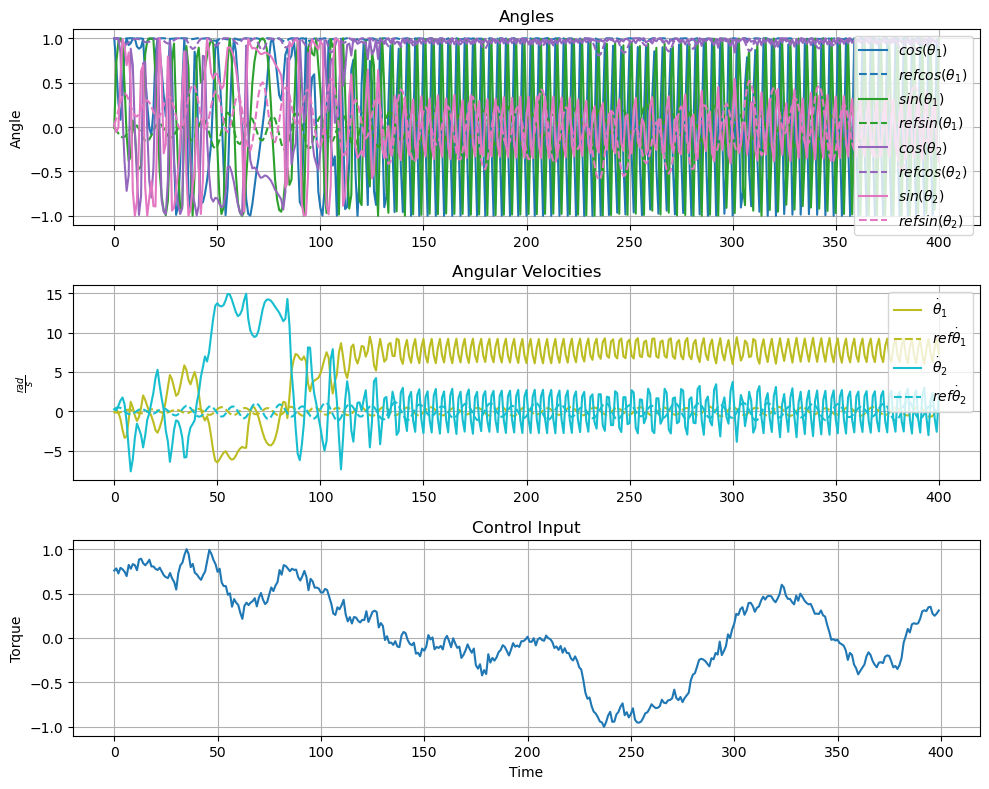

In [9]:
result = env_nssm(test_sim)
print({k: v.shape for k,v in test_sim.items()})
if env_str == "pendulum":
    plot_pendulum_sysid(result)
elif env_str == "acrobot":
    plot_acrobot_sysid(result)

# Control
Now that we have a somewhat accurate State Space representation of our Farama environment, we will build a controller for it.
To build this controller we are going to make sure that is going to produce control actions that are within the action bounds.
We can do this by using the Neuromancer `MLP_Bounds` class, which will apply a scaled and shifted sigmoid to our output dimension
and ensure that we only take valid actions.

In [13]:
policy = blocks.MLP_bounds(
    insize=env.ny,
    outsize=env.nu,
    hsizes=[128 for _ in range(2)],
    nonlin=activations['elu'],
    min=env.umin.item(),
    max=env.umax.item(),
)

policy_node = Node(policy, ["yn"], ["U"], name="policy")

## Interaction with Black Box

To interact with our black box, we must write a wrapper around it for interaction, we can do ths by writing an arbitrary callable that simply reshapes the data for our NSSM.
This just ensures that the output of our NSSM is the correct shape.

In [14]:
print(policy_node.input_keys)
print(policy_node.output_keys)
print(system_node.input_keys)
print(system_node.output_keys)


['yn']
['U']
['yn', 'U']
['approx_yn']


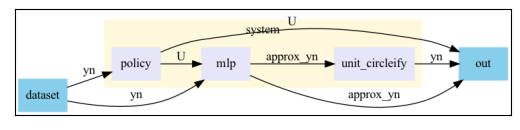

In [15]:
cl_system = System(
    [
        policy_node,
        system_node,
        unit_circleify,
    ], nsteps=400, name="cl_system"
)
cl_system.show()

# Gathering the Initial Conditions
We need to gather some initial conditions to roll out the control problem for the Pendulum/Acrobot system.
For this all we need to do is call `get_x0()` on our Farama system which will sample initial conditions in a similar manner to the original system.

The reason that we need to sample many random initial conditions instead of just using the same one for all control sequences is due to the fact that DPC is a non-stochastic algorithm. This means that at a given training step, if we give it two identical initial conditions, it is going to roll out an identical sequence of control.

In [16]:
def get_initial_conditions(nsim: int, name: str):
    y0s = []
    for _ in range(nsim):
        x0 = env.get_x0()
        y0s.append(env.get_y0(x0=x0))
    y0s = torch.stack(y0s).reshape(nsim, 1, env.ny)
    dataset = DictDataset(
        {
            "yn": y0s,
        },
        name=name,
    )
    loader = torch.utils.data.DataLoader(
        dataset,
        collate_fn=dataset.collate_fn,
        batch_size=10_000, # Arbitrarily large batch size
        shuffle=True,
    )
    return loader

train_loader = get_initial_conditions(100, name="train")
dev_loader = get_initial_conditions(20, name="dev")


# Creating the Control Optimization Problem
It makes sense to try to replicate the reward of the orignal system defined by [The Farama Foundation](https://gymnasium.farama.org/environments/classic_control/pendulum/) as
$r = -(\theta^2 + 0.1 * \dot\theta^2+ 0.001 * u^2)$.
To cast this to a minimization problem we will define $\mathbb{\cal{L}}=-r$.

In [17]:
yn = variable("yn")[:, 1:, :]
u = variable("U")
losses = []

th = torch.atan2(yn[:, :, 1], yn[:, :, 0])
u = u[:, :, 0]
th = wrap(th, -torch.pi, torch.pi)
thdot = yn[:, :, 2]
costs = th ** 2 + 0.1 * thdot**2 + 0.001 * (u**2)
loss = (costs == 0)
losses.append(loss)

obj = PenaltyLoss(losses, [])
problem = Problem([cl_system], obj)

opt = optim.Adam(cl_system.parameters(), 0.001)

# Training the Controller

Now that we have defined the full closed loop interaction between the controller and the NSSM, we can hand it to the trainer to learn a control policy.

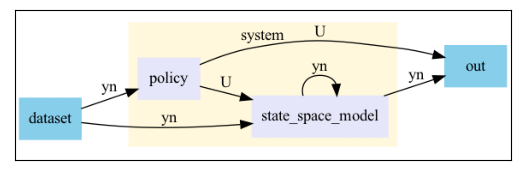

In [18]:
# If you want to skip the training proccess run this cell and skip the next

def load_controller(pkl_pth: str, state_dict_path: str, nsteps: int):
    import dill
    problem = torch.load(pkl_pth, pickle_module=dill, map_location=torch.device('cpu'))
    state_dict = torch.load(state_dict_path, map_location=torch.device('cpu'))
    problem.load_state_dict(state_dict)

    # Pull it out of the problem wrapper
    system = problem.nodes[0]

    # Get it ready for predictions
    system.nstep_key = "yn"
    system.nsteps = nsteps

    return system

system = load_controller(
    f"pretrained_weights/{env_str}_bb/{env_str}.pth",
    f"pretrained_weights/{env_str}_bb/{env_str}_state_dict.pth",
    400
)
best_model = system
best_model.show()

In [ ]:
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer=opt,
    epochs=100_000,
    patience=200,
    train_metric="train_loss",
    eval_metric="dev_loss",
)
best_model = trainer.train()

trainer.model.load_state_dict(best_model)
best_model = problem.nodes[0]


# Evaluation of the controller
We will extract the controller from the CL System and evaluate it on the original Farama system.


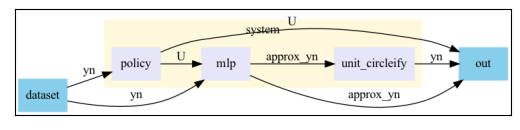

In [19]:
# current system
cl_system.show()

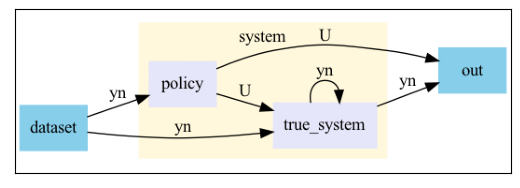

In [21]:
# swapping out the NSSM for the true system
length = 400
policy_node = best_model.nodes[0]
true_system = Node(env, ["yn", "U"], ["yn"], name="true_system")
cl_system = System(
    [
        policy_node,
        true_system,
    ], nsteps=length, name="cl_system"
)
best_model = cl_system
cl_system.show()

## Performance Metrics
It is very important to be able to see how your controller is performing visually with either plots or videos of control.
The nice thing about the Pendulum and Acrobot systems is that we can create gifs identical to the original Farama environment as we can simply backend to it for rendering.

loss=tensor([353.])


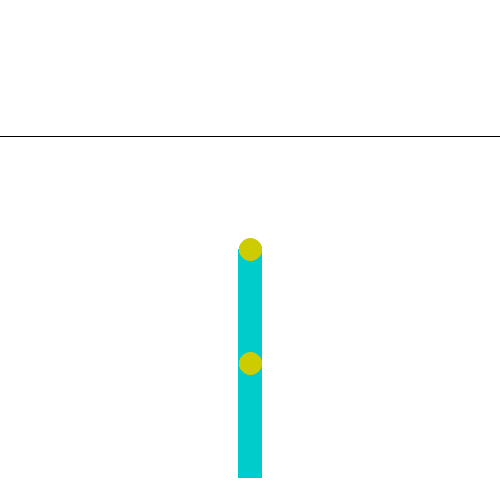

In [28]:

test_set = env.get_y0(x0=env.x0) # Start in downright position
test_set = test_set.reshape(1, 1, env.ny)
test_set = {
    "yn": test_set,
}

pred = best_model(test_set)

frames = []
loss = 0.0
for i in range(length):
    x = env.y_to_x(pred["yn"][:, i, :])
    loss += env.get_loss(pred['yn'][:, i, :], pred["U"][:, i, :])
    frames.append(render_gymnasium(x=x.detach().numpy().squeeze(), render_mode="rgb_array", env_str=env.env_str))

optimal_state = env.optimal_state.repeat(length + 1, 1).reshape(1, length + 1, env.ny)
pred["optimal_state"] = optimal_state
pred["Zero"] = torch.zeros_like(pred["U"])

import imageio
fps = 10_000 # This should usually be 30, but jupyter needs it to be larger
imageio.mimsave(f'{env_str}_bb_control.gif', frames, duration=length/fps)
frames = np.array(frames)

from IPython.display import Image
print(f"{loss=}")
Image(open(f'{env_str}_bb_control.gif','rb').read())


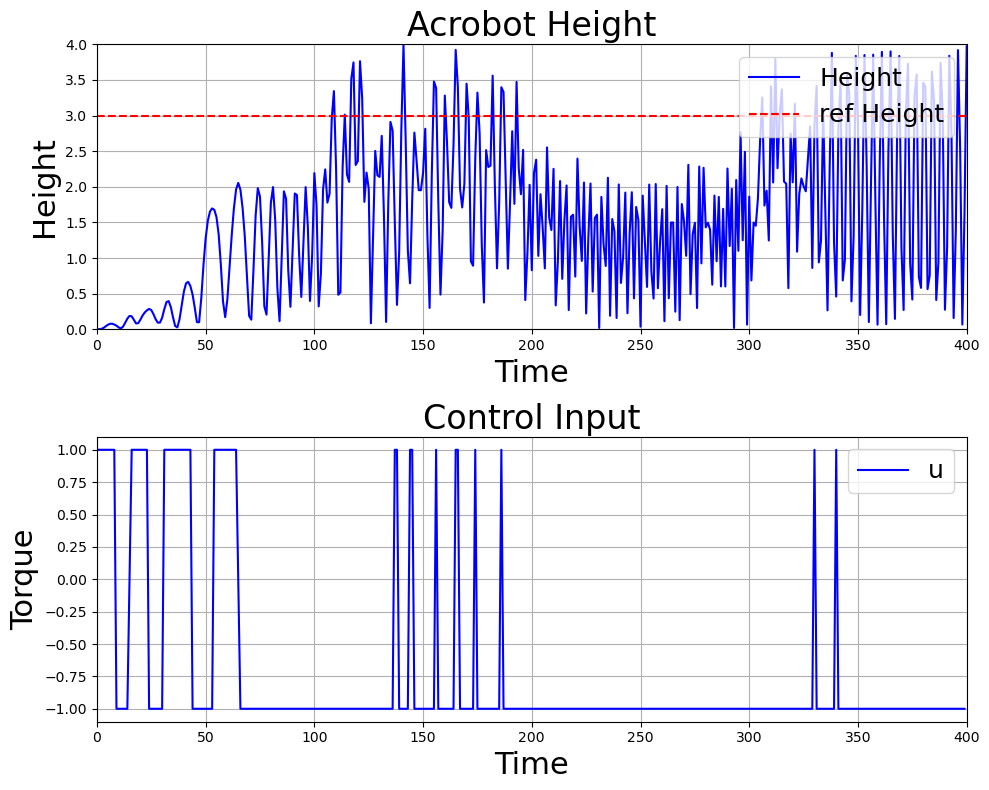

In [30]:
if env_str == "pendulum":
    plot_pendulum_control(pred)
else:
    plot_acrobot_control(pred)